# Прогнозирование вероятности оттока пользователей для фитнес-центров

In [1]:
import pandas as pd # импортируем библиотеки 
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
from plotly import graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools


In [2]:
try:
    data = pd.read_csv(r'C:\Users\KSGul\data\gym_churn.csv') # запишем в переменную data изучаемый файл
except:
    data = pd.read_csv('/datasets/gym_churn.csv')

display(data)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


In [3]:
data.shape

(4000, 14)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Таблица включает в себя 14 строк и 4000 наблюдений. 

Данные клиента за предыдущий до проверки факта оттока месяц
* `gender` — пол (1-женский пол, 0-мужской);
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр (1-проживание в районе, 0-нет);
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)(1-сотрудник/партнер, 0-нет);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)(1-привел друга, 0-нет);
* `Phone` — наличие контактного телефона(1-оставил телефон, 0-нет);
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий (1-посещает, 0-нет);
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `Churn` — факт оттока в текущем месяце (1-ушел, 0-нет).

**Первоначально обработаем данныепроверим на пропуски и дубликаты**

In [5]:
round((data.isna().mean()*100),2)

gender                               0.0
Near_Location                        0.0
Partner                              0.0
Promo_friends                        0.0
Phone                                0.0
Contract_period                      0.0
Group_visits                         0.0
Age                                  0.0
Avg_additional_charges_total         0.0
Month_to_end_contract                0.0
Lifetime                             0.0
Avg_class_frequency_total            0.0
Avg_class_frequency_current_month    0.0
Churn                                0.0
dtype: float64

**Пропусков не обнаружено** 

In [6]:
data.duplicated().sum()

0

**Дубликаты отсутсвуют**

In [7]:
data.columns = data.columns.str.lower() #Перевод наименований столбцов к нижнему регистру

In [8]:
for col in data.columns: #Изучение средних значений и стандартных отклонейний
    print(data[col].describe())

count    4000.000000
mean        0.510250
std         0.499957
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64
count    4000.000000
mean        0.845250
std         0.361711
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: near_location, dtype: float64
count    4000.000000
mean        0.486750
std         0.499887
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: partner, dtype: float64
count    4000.000000
mean        0.308500
std         0.461932
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: promo_friends, dtype: float64
count    4000.000000
mean        0.903500
std         0.295313
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: phone, dtype: float64
c

* Соотношение мужчин и женщин практически равно;
* Значительно преобладают клиенты живущие вблизи фитнес-центра;
* Больше 50% клиентов не имеют статуса "партнёр";
* Большинство клиентов не использует функцию "приведи друга";
* Преобладающее большинство оставляет свой номер телефона;
* более 50% клиентов предпочитают покупать абонемент на 1 месяц;
* Меньеш 50% посещают групповые занятия;
* В среднем клиенты занимаются более 3 месяцев с момента первого обращения;
* В среднем клиенты занимаются 2 раза в неделю;
* Большая часть клиентов остаются в клубе.

**Рассмотрим средние значения по группам оттока**

In [9]:
data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


**Основные различия:**

* Клиенты не партнеры клуба и не использующие функцию "приведи друга" склонны к оттоку;
* Клиенты, остающиеся в клубе, склонны приобретать аббонементы на срок более 1 месяца;
* Клиенты, которые тратят больше средств в клубе, не склонны к оттоку;
* Клиенты не прозанимавшиеся длительный срок склонны к оттоку; 
* Клиенты, которые занимаются 2 и более раз в неделею менее склонны к оттоку.

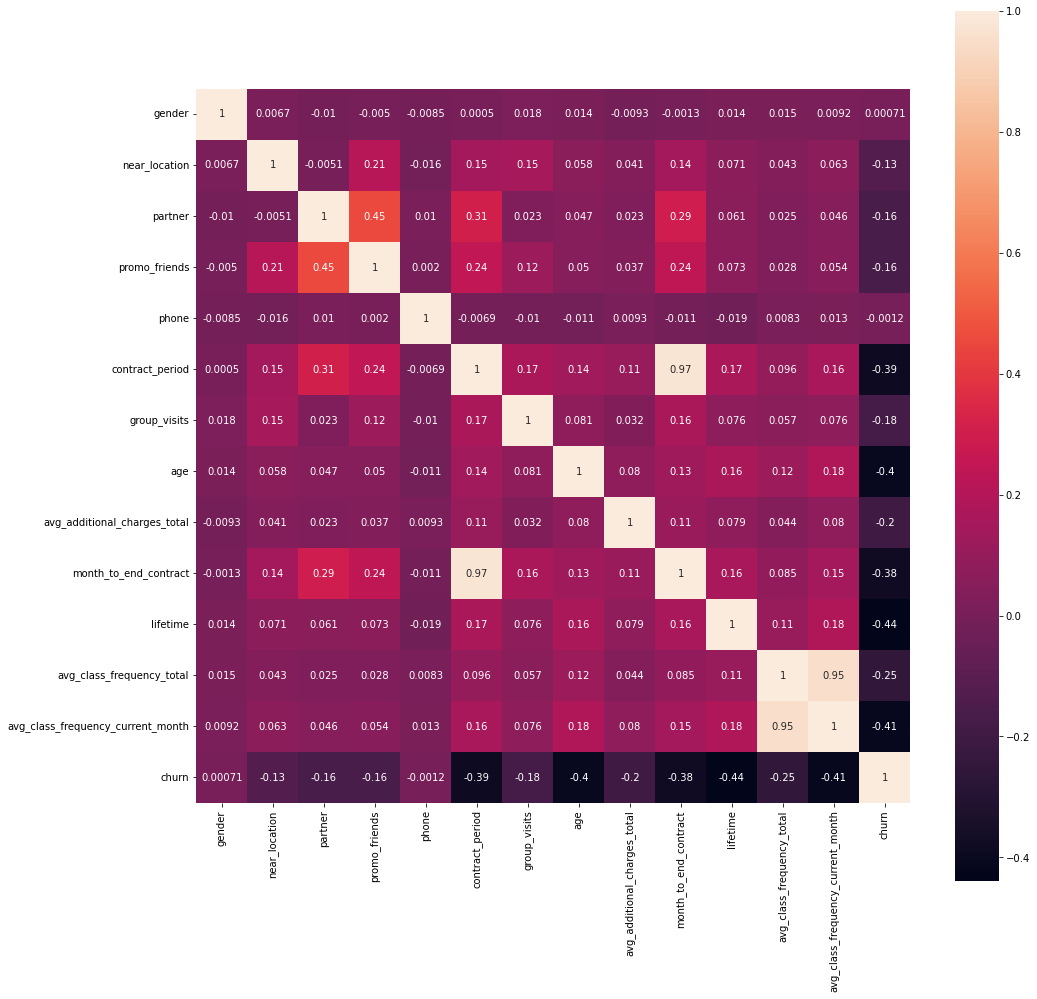

In [13]:
cm = data.corr() #вычисляем матрицу корреляций

plt.figure(figsize=(16, 16))
#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True) 
plt.show()

**Выводы по матрице корреляции:**

* Наиболее коррелирующие признаки (Среднее количество посещений в неделю за последний месяц и за весь период, срок абонемента и количество месяцев до конца абонемента);
* Остальные признаки коррелируют значительно слабее, либо не коррелируют вовсе.

## Построение модели прогнозирования оттока клиентов

In [14]:
X = data.drop('churn', axis=1) # список признаков и их значения
y = data['churn'] #Вектор целевого признака по оттоку клиентов

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #Разбивка данных на обучающую и валидационную выборки в соотношении 80 на 20

In [16]:
model_lr = LogisticRegression(random_state=0) #Задаем алгоритм логистической регрессии 
model_tree = RandomForestClassifier(random_state=0)#Задаем алгоритм случайного леса

In [19]:
model_lr.fit(X_train, y_train) #Обучение модели логистической регрессии 
model_tree.fit(X_train, y_train)#Обучение модели случайным лесом 

RandomForestClassifier(random_state=0)

In [20]:
predictions_lr = model_lr.predict(X_test) #Прогноз на валидационной выборке методом логистической регресии 
predictions_tree = model_tree.predict(X_test) #Прогноз на валидационной выборке методом случайного леса

Оценка метрик `accuracy`,`precision` и `recall` для обеих моделей на валидационной выборке

* `accuracy` - доля правильных ответов. Это доля верно угаданных ответов из всех прогнозов. Чем ближе значение accuracy к 100%, тем лучше.
* `precision` - точность. Precision говорит, какая доля прогнозов относительно "1" класса верна. То есть смотрим долю правильных ответов только среди целевого класса.
* `recall` - точность. Сколько реальных объектов "1" класса вы смогли обнаружить с помощью модели

In [22]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions_lr)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions_lr)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions_lr)))

Accuracy: 0.90
Precision: 0.81
Recall: 0.79


In [23]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions_tree)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions_tree)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions_tree)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.82


**Обе модели достаточно хорошо справились с предсказанием верных ответов, но способ основанный на решении методом случайного леса показал себя лучше по всем 3 параметрам.**

**Рассмотрим обучение модели исключив один из коррелирующих признаков.**

In [24]:
data_new = data.drop('contract_period', axis=1)

In [25]:
X = data_new.drop('churn', axis=1)
y = data_new['churn']

In [26]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=0)

In [27]:
model_lr_new = LogisticRegression(random_state=0)
model_tree_new = RandomForestClassifier(random_state=0)

In [30]:
model_lr_new.fit(X_train_new, y_train_new)
model_tree_new.fit(X_train_new, y_train_new)

RandomForestClassifier(random_state=0)

In [31]:
predictions_lr_new = model_lr_new.predict(X_test_new)
predictions_tree_new = model_tree_new.predict(X_test_new)

In [33]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_new, predictions_lr_new)))
print('Precision: {:.2f}'.format(precision_score(y_test_new, predictions_lr_new)))
print('Recall: {:.2f}'.format(recall_score(y_test_new, predictions_lr_new)))

Accuracy: 0.92
Precision: 0.85
Recall: 0.80


In [34]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_new, predictions_tree_new)))
print('Precision: {:.2f}'.format(precision_score(y_test_new, predictions_tree_new)))
print('Recall: {:.2f}'.format(recall_score(y_test_new, predictions_tree_new)))

Accuracy: 0.92
Precision: 0.85
Recall: 0.83


**После удаления одного из коррелирующих признаков обе модели улучшили свои показатели, при этом решение основанное на методе логистической регрессии практически идентично случайному лесу.**

Также в работе была рассмотрена ситуация с удалением еще оддного коррелирующего признака, однако это только ухудшило прогнозы моделей.

## Кластеризация клиентов

In [35]:
scaler = StandardScaler() # Стандартизирование данных

In [36]:
data_sc = scaler.fit_transform(data_new) 

In [37]:
linked = linkage(data_sc, method = 'ward') #Построение матрицы расстояний

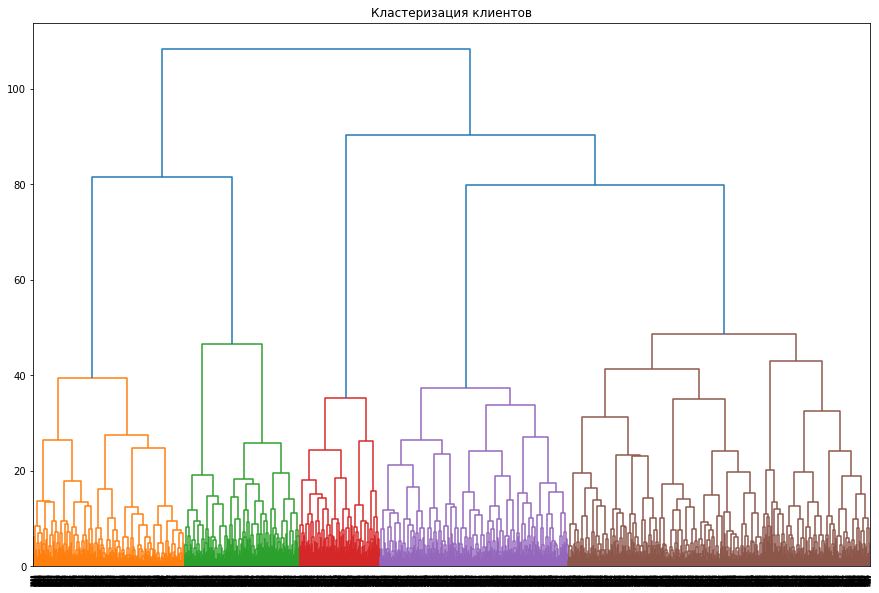

In [38]:
plt.figure(figsize=(15, 10))  #Отрисовка дендограммы
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show() 

**На основе дендограммы можно выделить 5 основных кластеров**

In [39]:
km = KMeans(n_clusters=5, random_state=0) #Обучение модели кластеризации на основании алгоритма K-Means 
labels = km.fit_predict(data_sc)

In [40]:
data_new['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
display(data_new.groupby('cluster_km').mean())

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,
0,0.508976,0.761352,0.344245,0.179514,0.998944,0.256600,26.898627,115.368963,1.610348,0.975713,1.449221,1.023840,0.996832
1,0.548422,0.840044,0.330794,0.055495,0.998912,0.448313,29.953210,160.733433,4.461371,4.700762,2.917772,2.923505,0.004353
2,0.503464,0.971132,0.907621,0.980370,1.000000,0.553118,29.821016,157.774591,7.041570,4.672055,1.996872,1.996018,0.011547
3,0.526042,0.864583,0.473958,0.307292,0.000000,0.427083,29.296875,144.096612,4.466146,3.932292,1.851384,1.720629,0.265625
4,0.471719,0.808824,0.394796,0.052036,1.000000,0.397059,30.160633,157.059483,4.358597,4.636878,1.156120,1.156851,0.001131


* В кластере 2 собраны клиенты партнеры клуба и использующие функцию "приведи друга";
* В кластере 3 клиенты не оставляют свой номер телефона; 
* В класстере 1 собраны клиенты с наибольшими средними тратами и с наибльшим количеством средних посещений в неделю за период;
* В класстре 0 на первый взгялд собраны клиенты с наибольшим шансом оттока.

In [41]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


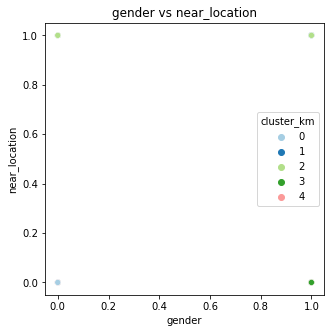

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


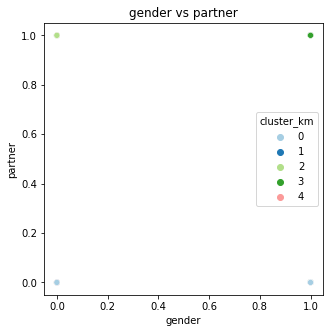

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


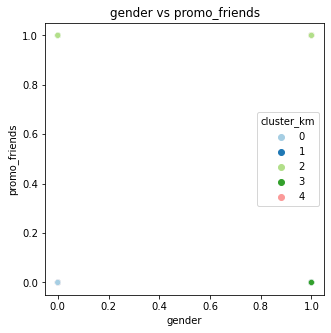

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


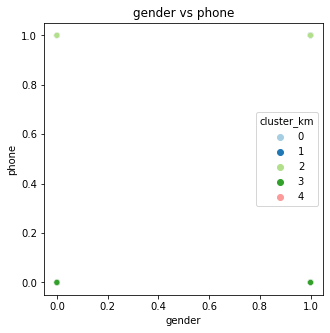

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


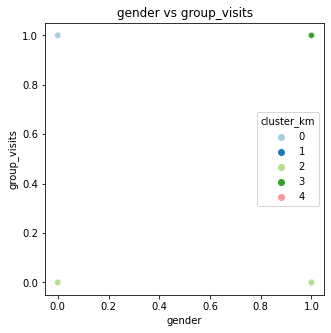

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


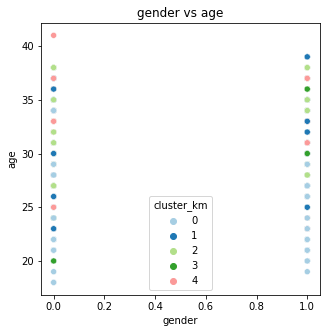

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


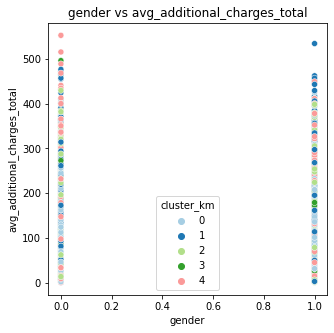

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


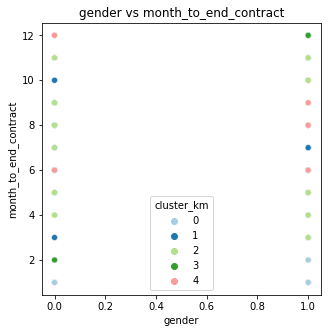

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


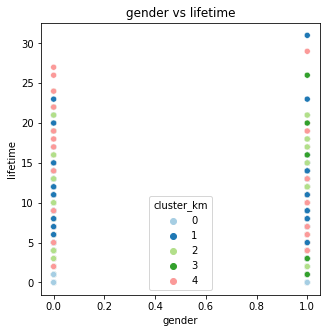

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


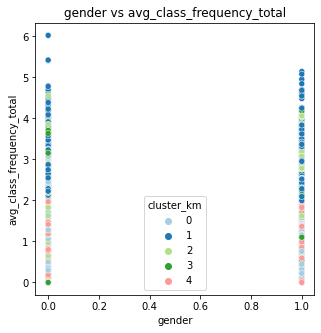

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


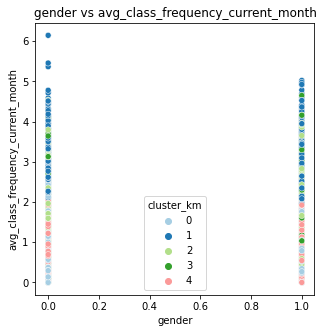

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


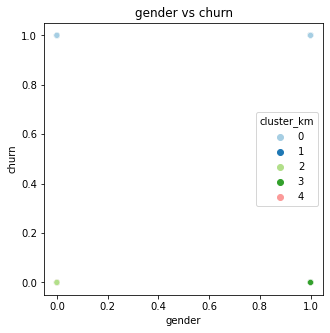

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


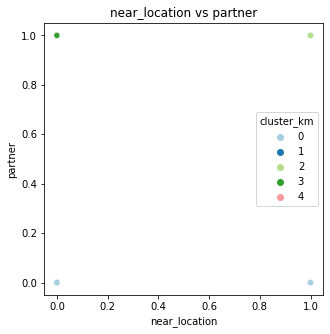

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


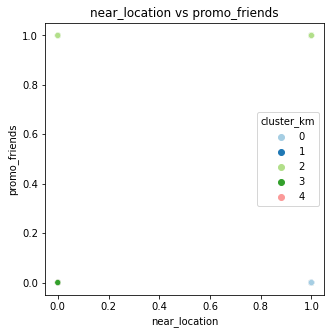

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


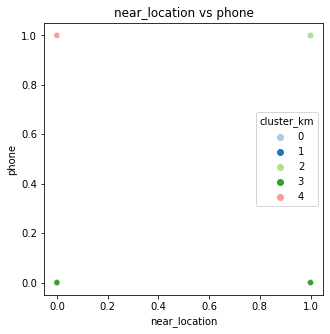

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


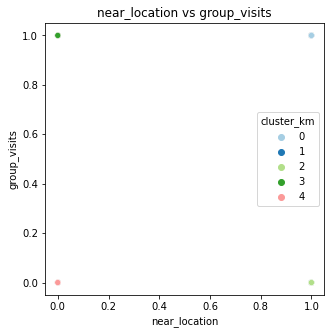

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


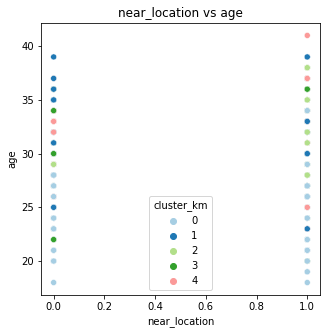

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


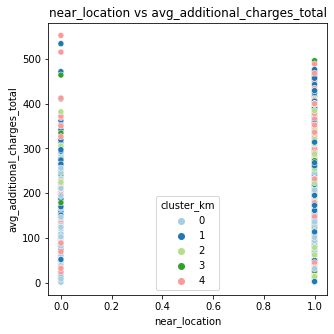

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


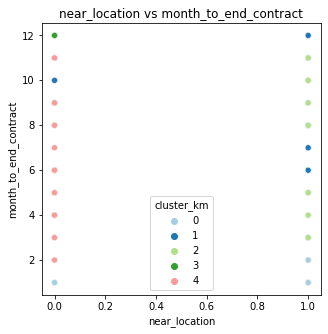

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


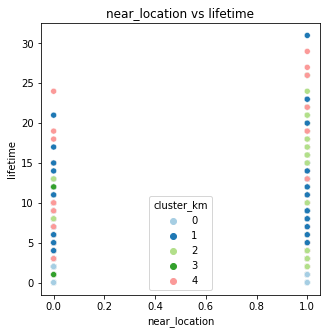

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


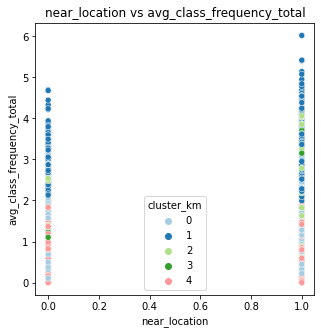

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


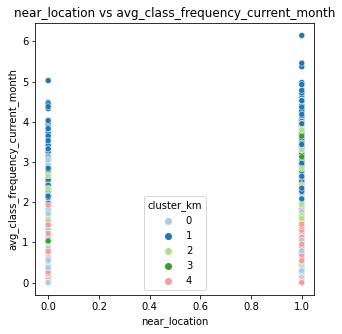

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


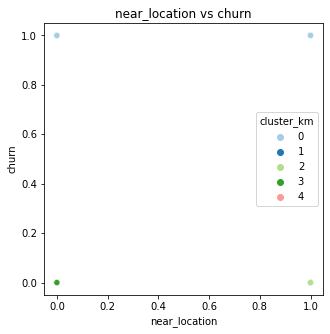

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


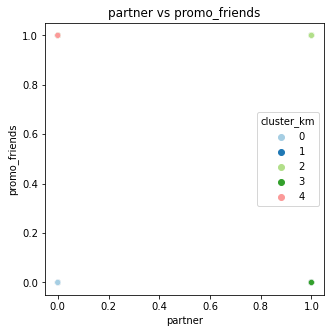

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


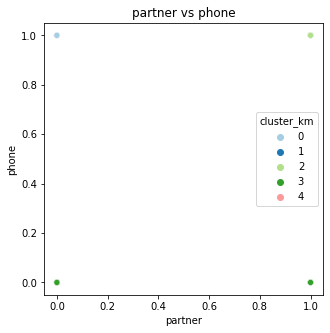

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


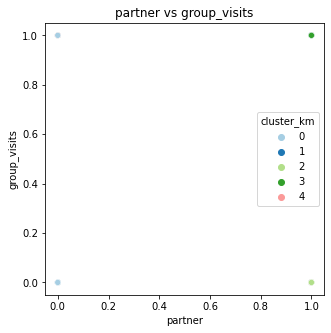

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


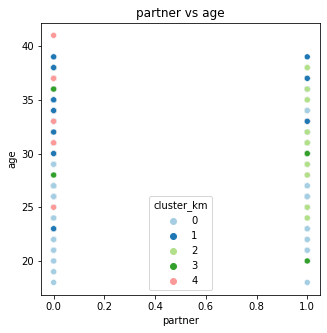

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


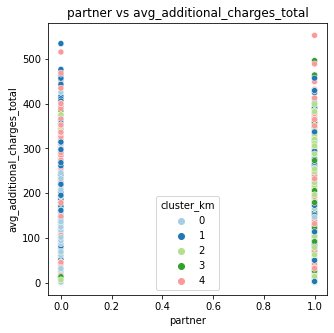

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


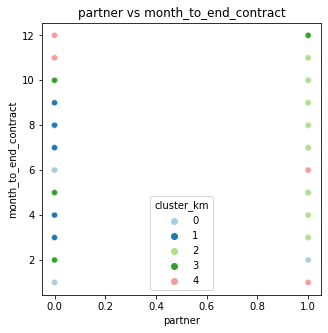

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


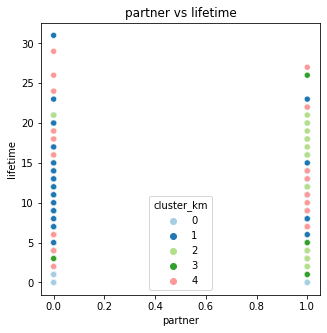

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


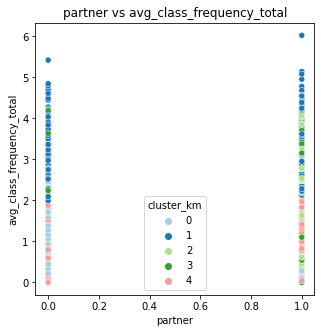

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


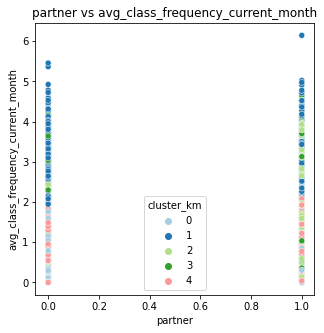

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


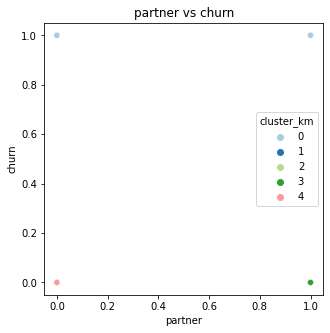

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


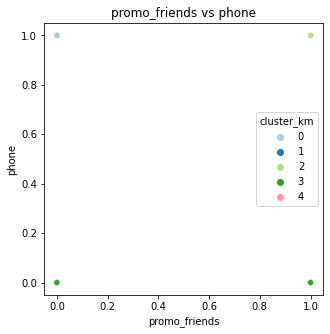

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


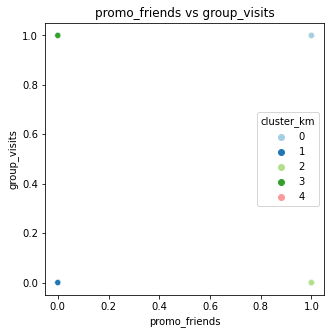

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


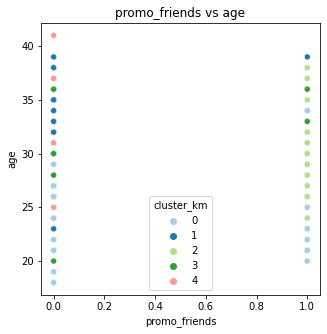

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


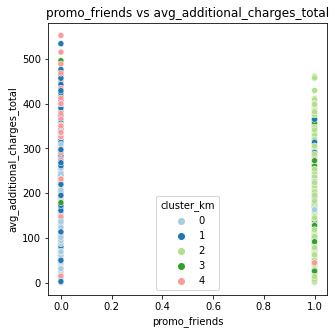

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


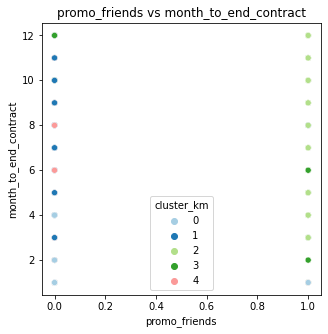

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


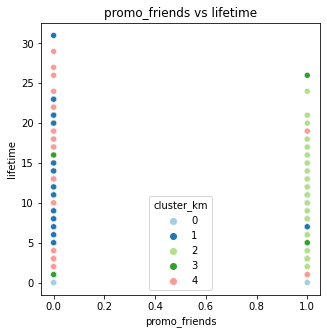

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


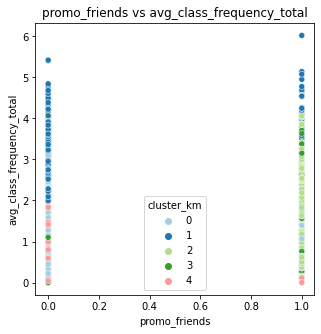

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


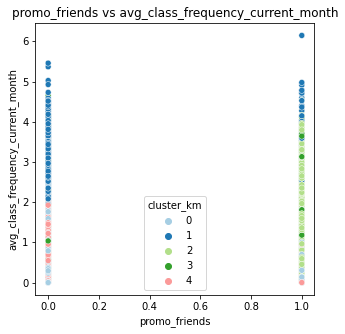

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


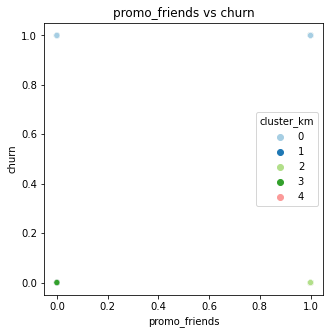

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


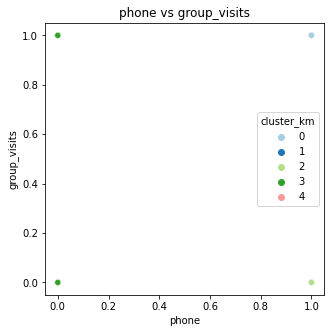

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


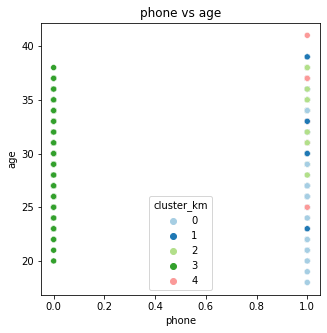

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


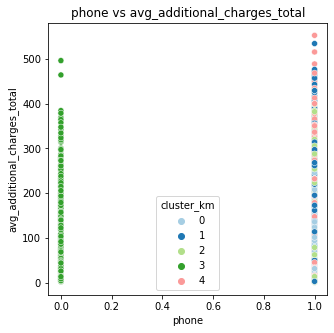

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


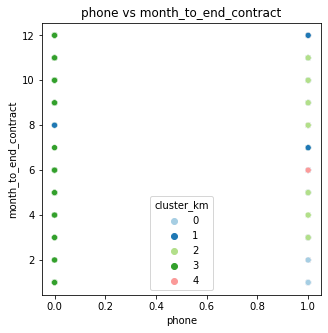

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


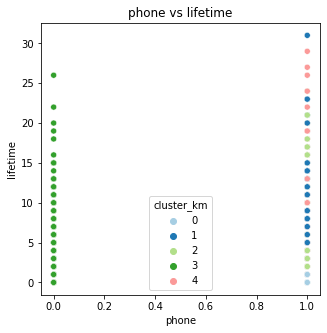

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


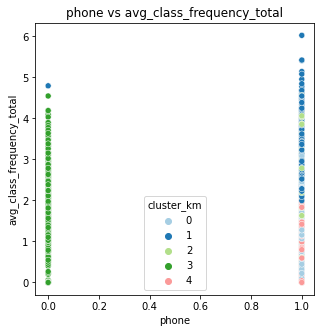

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


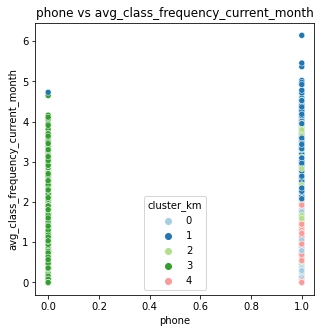

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


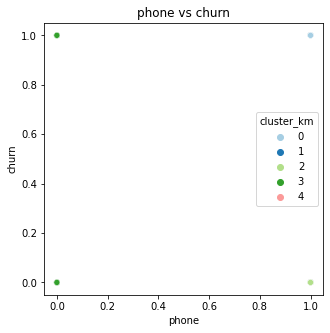

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


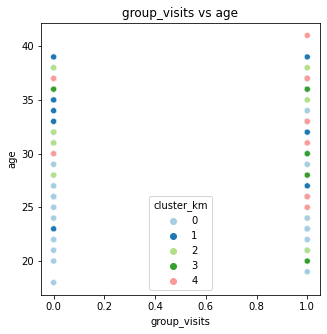

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


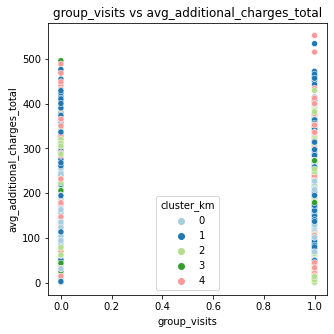

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


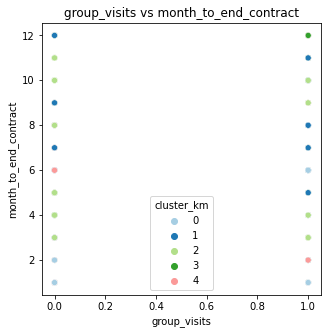

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


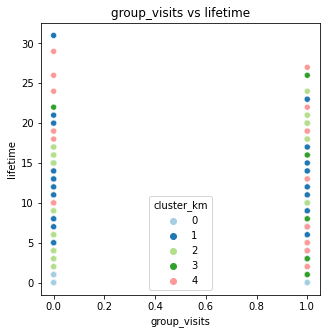

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


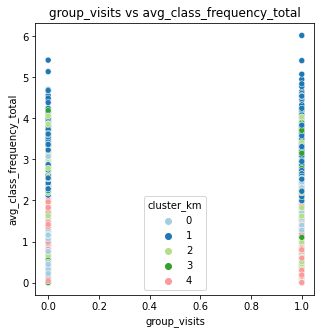

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


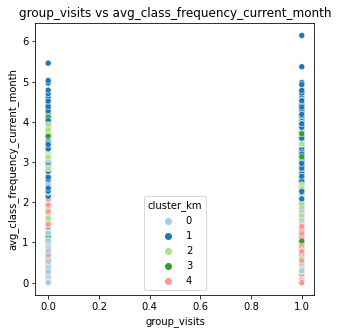

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


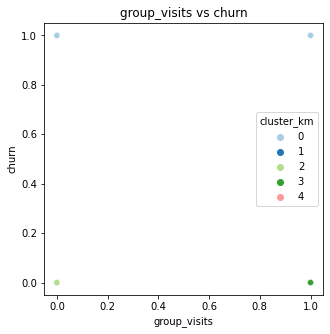

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


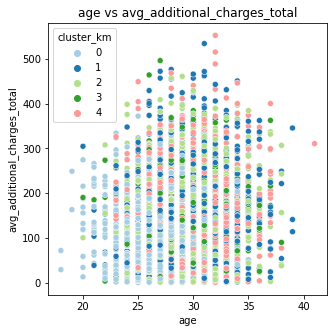

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


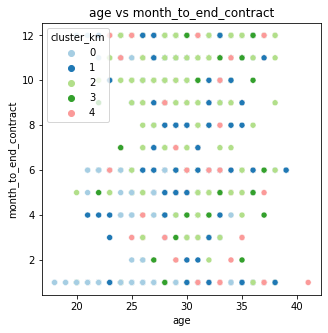

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


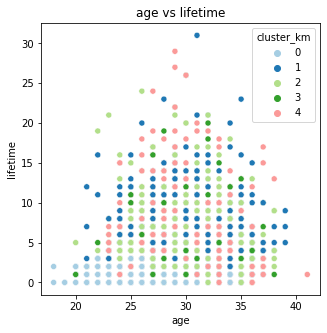

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


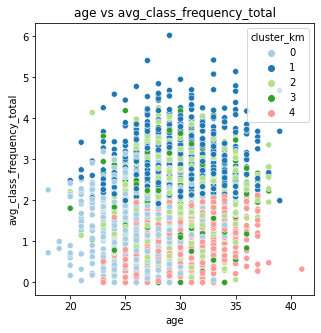

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


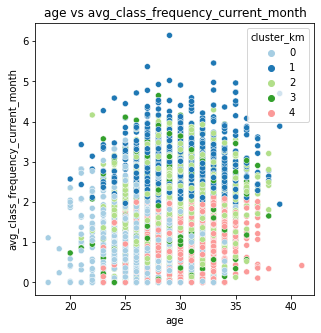

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


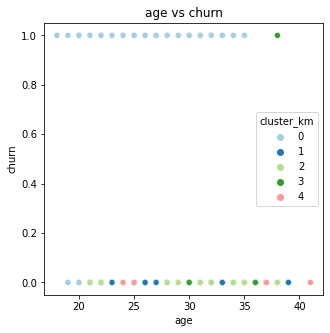

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


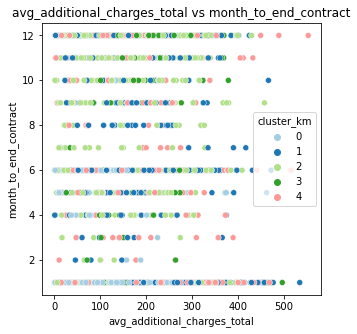

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


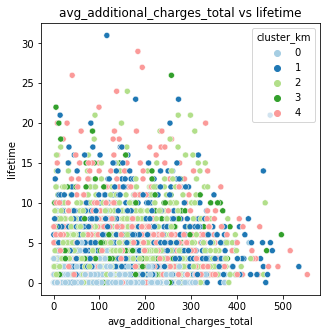

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


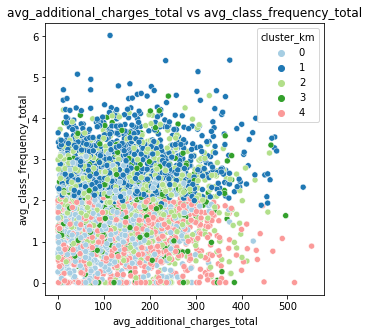

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


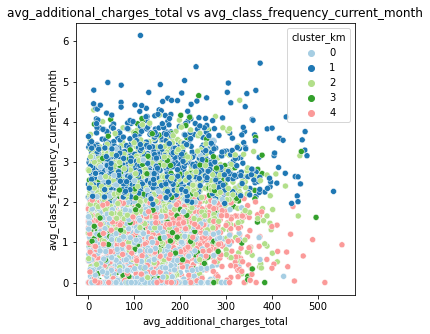

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


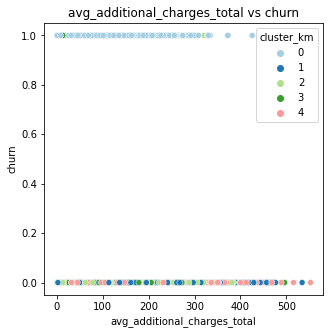

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


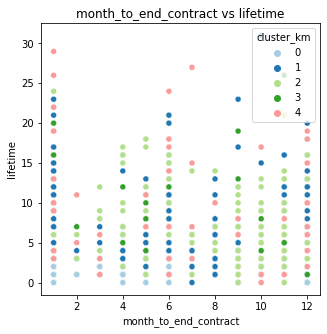

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


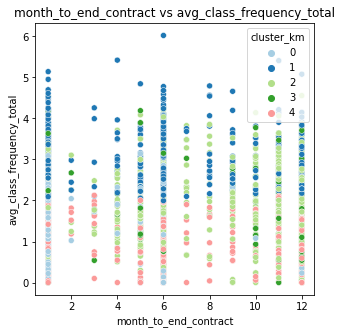

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


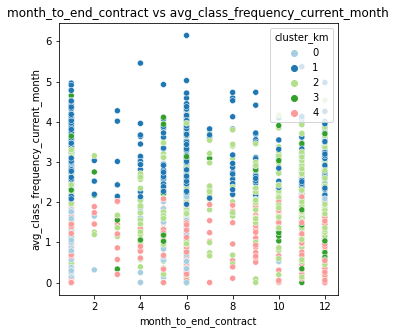

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


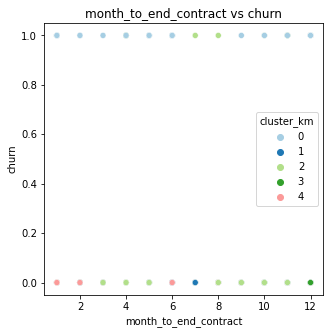

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


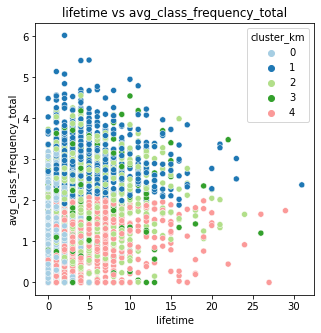

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


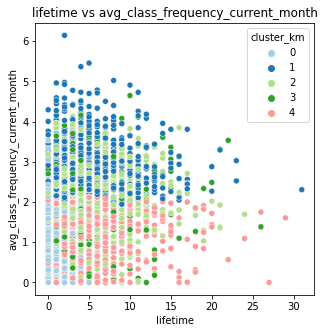

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


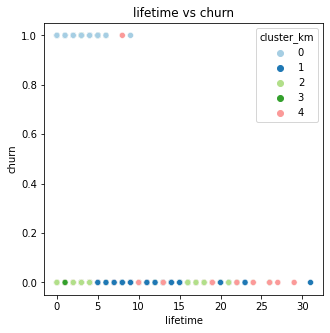

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


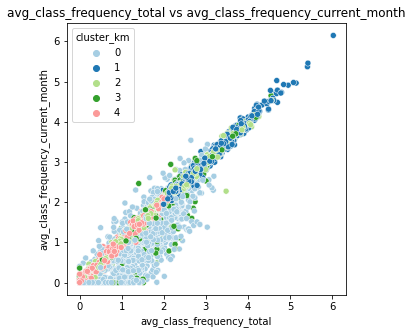

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


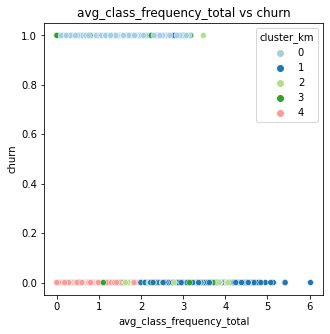

C:\Users\KSGul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


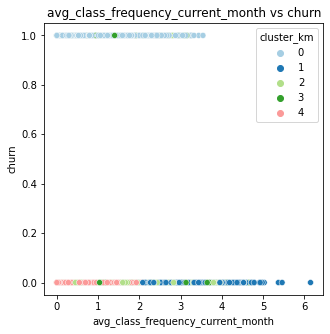

In [42]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(data_new.drop('cluster_km', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(data_new, pair[0], pair[1], 'cluster_km')

**По графикам видно, что нет явного разделения у признаков, однако кластер 2 склонен к длительным абонементам и более частым занятиям.**

In [43]:
data_new.groupby('cluster_km')['churn'].mean()

cluster_km
0    0.996832
1    0.004353
2    0.011547
3    0.265625
4    0.001131
Name: churn, dtype: float64

Как и было сказано ранее кластер 0 наиболее склонен к оттоку клиентов, а кластер 1 и 4 практически не имеют оттока среди своих клиентов. Также кластер 2 показывает низкие значения по оттоку клиентов. 

## Выводы

1. В части прогнозирования целевого показателя оттока клиентов одинаково хорошо и на высоком уровне показали себя методы логистической регрессии и случайного леса;
2. Всех клиентов фитнес-центров удалось разделить на 5 основных кластеров;
3. Низкий отток клиентов показывает 1 кластер, его лучшие признаки - среднее количество посещений в неделю за период и наиболее длительные абонементы.
4. Также низкий отток продемонстрировал 2 кластер, его характерные признаки - партнеры клубов и занятия с друзьями;
5. 0 кластер демонстрирует наибольший отток клиентов, клиенты данного кластера редко посещают больше 1 тренировки в неделю;
6. Также высокий отток клиентов в кластере 3, клиенты данного кластера не оставляют номер телефона;
7. Наиболее низкий процент оттока показал 4 кластер, клиенты данного кластера имеют наибольший средний возраст и небольшое преобладание мужского пола.

**Рекомендации для бизнеса:**

* Анализ показывает, что чем чаще клиент тренируется, тем меньше вероятность оттока клиента, следовательно необходимо продвигать в клубе политику регуляных тренировок;
* Также стоит сделать дополнительные акции/бонусы для партнеров клуба и друзей клиентов, так как данные группы клиентов не склонны к оттоку;
* Стоит рассмотреть подбор наиболее удобного фитнес-центра из сети к месту жительства клиента, тогда есть шанс снизить отток клиентов.
* Чем дольше абонемент, тем ниже шанс оттока, следует рассмотреть возможность введения скидок при покупки длительных абонементов.